# Read WFS data from USGS ScienceBase into Shapely/Cartopy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geojson
from owslib.wfs import WebFeatureService
from shapely.geometry import Polygon, mapping, asShape, shape
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOpenAerial, MapQuestOSM, OSM
%matplotlib inline


In [2]:
# Read shapefile data from USGS ScienceBase WFS 1.1 service in JSON format
# (shapefile was previosly uploaded to ScienceBase, creating the WFS service)

In [3]:
# getCapabilities
#https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c54be4b0aa151574a8dc?service=wfs&version=1.0.0&request=GetCapabilities
# containes LatLongBoundingBox for each feature

In [4]:
# some USGS ScienceBase Geoserver WFS endpoints:
#endpoint='https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c54be4b0aa151574a8dc'
endpoint='https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c5fce4b0aa151574a8ed'
#endpoint='https://www.sciencebase.gov/catalogMaps/mapping/ows/5342e124e4b0aa151574a969'
wfs = WebFeatureService(endpoint, version='1.1.0')
print wfs.version

1.1.0


In [5]:
shp = wfs.contents.keys()
print shp

['sb:footprint', 'sb:Conservation_Zone_WGS84']


In [6]:
a = wfs.contents['sb:footprint']
b = a.boundingBoxWGS84

In [7]:
shp = filter(lambda a: a != 'sb:footprint', shp)
print shp

['sb:Conservation_Zone_WGS84']


In [8]:
def flip_geojson_coordinates(geo):
    if isinstance(geo, dict):
        for k, v in geo.iteritems():
            if k == "coordinates":
                z = np.asarray(geo[k])
                f = z.flatten()
                geo[k] = np.dstack((f[1::2], f[::2])).reshape(z.shape).tolist()
            else:
                flip_geojson_coordinates(v)
    elif isinstance(geo, list):
        for k in geo:
            flip_geojson_coordinates(k)

In [9]:
#srs='EPSG:4326' # v1.0 syntax
srs='urn:x-ogc:def:crs:EPSG:4326'  # v1.1 syntax
json_response = wfs.getfeature(typename=[shp[0]], propertyname=None, srsname=srs, outputFormat='application/json').read()
geo = geojson.loads(json_response)
flip_geojson_coordinates(geo)

In [10]:
print geo.keys()

['crs', 'type', 'features']


In [11]:
print geo['type']

FeatureCollection


bounds from Shapely:  (-74.12113865030754, 39.77069522703161, -74.09384984325125, 39.81488113835475)


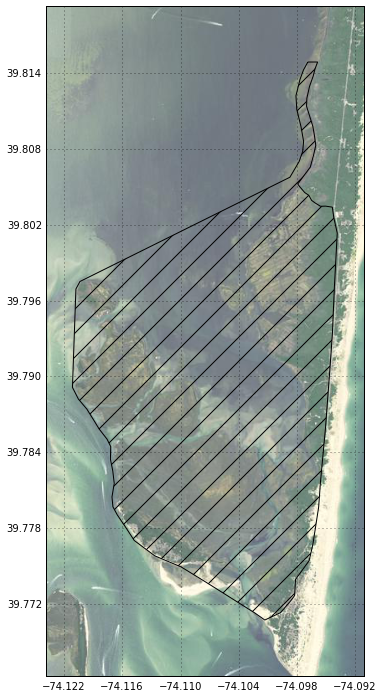

In [12]:
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

plt.figure(figsize=(12,12))
# Open Source Imagery from MapQuest (max zoom = 16?)
tiler = MapQuestOpenAerial()
# Open Street Map (max zoom = 18?)
#tiler = OSM()
ax = plt.axes(projection=tiler.crs)
dx=b[2]-b[0]
dy=b[3]-b[1]
extent = (b[0]-0.1*dx,b[2]+0.1*dx,b[1]-0.1*dy,b[3]+0.1*dy)
ax.set_extent(extent, geodetic)
ax.add_image(tiler, 14)
#ax.add_geometries([polygon],ccrs.PlateCarree(),
#                          facecolor=BLUE, edgecolor=GRAY,alpha=0.5)
for p in geo.get("features", []):
    multi_poly = asShape(p.get("geometry"))
    print 'bounds from Shapely: ',multi_poly.bounds
#    name=p['properties']['NAME']
#    print name
    ax.add_geometries(multi_poly,ccrs.PlateCarree(),
                edgecolor='black',facecolor='none',hatch='/')
#title(name)
    
gl=ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#ax.add_feature(coast_10m,edgecolor='black')
#ax.coastlines()